In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'+'nue_check/' 
output_filedir = outputdir
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.18/04


In [2]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [3]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/25.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/25.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

# Nue cross check
The filter must pass fewer than 45 electron neutrino events normalized to 6.6E20 POT
counted within a range of true neutrino energy between 50 MeV to 1.5 GeV using a
sample of ~300,000 cosmic-overlaid charged current electron neutrino interactions in the
TPC

In [10]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"nue_check.root","RECREATE");
filename_overlay = 'NuCCana_nue_V26.root'
tree_name = 'numuCCAna'

overlay = ROOT.TChain(tree_name + "/event","event")
overlay.Add( inputdir + filename_overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
print 'POT: ',pot_overlay
pot_run3G1 = 2.1e20
scale = pot_run3G1/pot_overlay

POT:  7.7735612227e+22


In [11]:
filename_overlay = filename_overlay+'out4.root'
tree_name = 't_out'

overlay_out = ROOT.TChain(tree_name, "t_out")
overlay_out.Add( inputdir + filename_overlay)

print 'Entries TTree: ',overlay.GetEntries()
print 'Entries Tout: ',overlay_out.GetEntries()

Entries TTree:  130980
Entries Tout:  130979


In [12]:
fidVol = '(Nu_Vx_sce>(-1.55) && Nu_Vx_sce<(254.8)) && (Nu_Vy_sce>(-115.53) && Nu_Vy_sce<(117.47)) &&(Nu_Vz_sce>(-0.1) && Nu_Vz_sce<(1036.9))'
MCfidVol = '(MCNu_Vx>(-1.55) && MCNu_Vx<(254.8)) && (MCNu_Vy>(-115.53) && MCNu_Vy<(117.47)) &&(MCNu_Vz>(-0.1) && MCNu_Vz<(1036.9))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
sample = [overlay,overlay_out]
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [13]:
fidVol = '(Nu_Vx_sce>(-1.55) && Nu_Vx_sce<(254.8)) && (Nu_Vy_sce>(-115.53) && Nu_Vy_sce<(117.47)) &&(Nu_Vz_sce>(-0.1) && Nu_Vz_sce<(1036.9))'
overlay.SetAlias('fidVol',fidVol)
overlay_out.SetAlias('fidVol',fidVol)
overlay.SetAlias('muon','(track_key == key_muon)')
overlay_out.SetAlias('muon','(track_key == key_muon)')

track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'
track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'

overlay.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)

overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

overlay.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [18]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
this_cut = ' && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCTrackPurity>0.5 && MCTrackPDG==11'
#nue_pass_rate = overlay.GetEntries(cut+this_cut)
#print 'Nues passing cut: ', nue_pass_rate

nue_tot_rate0 = overlay_out.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05')*scale
print 'Nues (tot): ', nue_tot_rate0

nue_tot_rate1 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol')*scale
print 'Nues (tot in fidVol): ', nue_tot_rate1, '={:04.2f} %'.format((nue_tot_rate1*100.0)/nue_tot_rate0)

nue_tot_rate2 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && fidVol')*scale
print 'electrons (tot in fidVol): ', nue_tot_rate2, '={:04.2f} %'.format((nue_tot_rate2*100.0)/nue_tot_rate1)

nue_tot_rate3 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 && fidVol')*scale
print 'matched electrons (tot in fidVol): ', nue_tot_rate3, '={:04.2f} %'.format((nue_tot_rate3*100.0)/nue_tot_rate1)


nue_tot_rate4 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
                        MCTrackPurity>0.5 && fidVol')*scale
print 'matched electrons (tot in fidVol, purity>0.5): ', nue_tot_rate4, '={:04.2f} %'.format((nue_tot_rate4*100.0)/nue_tot_rate1)

nue_tot_rate5 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
                        MCTrackPurity>0.5 && fidVol && NuShowers==0')*scale
print 'matched electrons (tot in fidVol, purity>0.5): ', nue_tot_rate5, '={:04.2f} %'.format((nue_tot_rate5*100.0)/nue_tot_rate1)


Nues (tot):  179.839195955
Nues (tot in fidVol):  179.839195955 =100.00 %
electrons (tot in fidVol):  137.553171496 =76.49 %
matched electrons (tot in fidVol):  13.4884124529 =7.50 %
matched electrons (tot in fidVol, purity>0.5):  8.03685700932 =4.47 %
matched electrons (tot in fidVol, purity>0.5):  0.00540292908189 =0.00 %


In [9]:
overlay.Draw('MCTrackPurity'+'>>h_temp1','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCTrackPDG==11','')


14244L

Entries 66545.0
52796
7.76005759835


Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h_purity_allTracks.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h_purity_allTracks.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h_purity_allTracks.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h_purity.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h_purity.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h_purity.pdf has been created


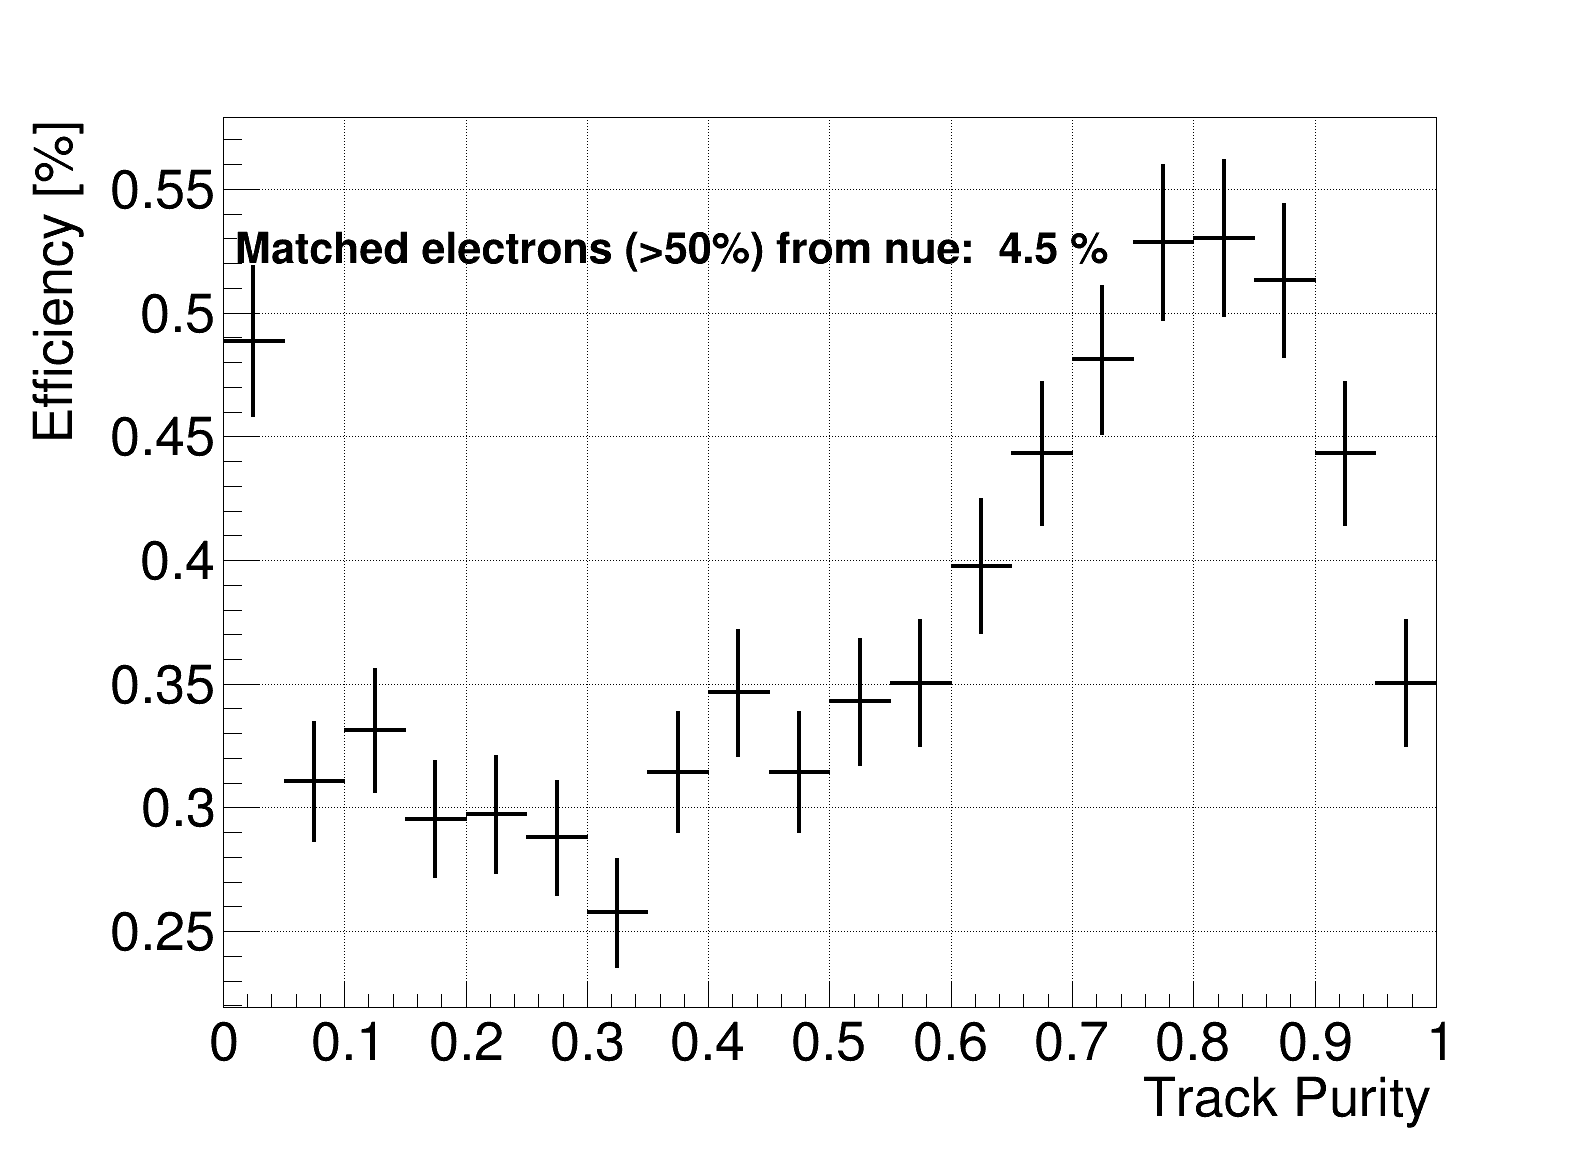

In [10]:
h_temp = ROOT.TH1F("h_temp",'h_temp',200,0,1)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',200,0,1)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',20,0,1)

matching = 'MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1'


overlay.Draw('MCTrackPurity'+'>>h_temp','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05','')
overlay.Draw('MCTrackPurity'+'>>h_temp1','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCTrackPDG==11','')

h_temp.SetXTitle("Track Purity (all tracks in nu event)")
h_temp.SetYTitle("# events")
h_temp.GetYaxis().SetTitleSize(0.05)
h_temp.GetYaxis().SetTitleOffset(1.3)
h_temp.GetYaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleSize(0.05)
h_temp.GetXaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleOffset(1)
h_temp.SetLineColor(ROOT.kBlack)
h_temp.SetLineWidth(4)
h_temp1.SetLineColor(ROOT.kGreen)
h_temp1.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_temp.Draw('')
h_temp1.Draw('same')
prelim = draw_sim()
prelim.Draw()
legend = ROOT.TLegend(0.15,0.65,0.5,0.9)
legend.AddEntry(h_temp,'all nue',"lep");
legend.AddEntry(h_temp1,'matched nue',"lep");
legend.Draw()
print "Entries", h_temp.GetEntries()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h_purity_allTracks.root")
c1.SaveAs(outputdir_png + "h_purity_allTracks.png")
c1.SaveAs(outputdir_pdf + "h_purity_allTracks.pdf")

overlay.Draw('MCTrackPurity'+'>>h_temp2','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 &&'+matching,'')
nue_tot_rate = overlay_out.GetEntries('MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05')
print nue_tot_rate
h_temp2.Scale(100.0/nue_tot_rate)
h_temp2.SetXTitle("Track Purity")
h_temp2.SetYTitle("Efficiency [%]")
h_temp2.GetYaxis().SetTitleSize(0.05)
h_temp2.GetYaxis().SetTitleOffset(1.3)
h_temp2.GetYaxis().SetLabelSize(0.05)
h_temp2.GetXaxis().SetTitleSize(0.05)
h_temp2.GetXaxis().SetLabelSize(0.05)
h_temp2.GetXaxis().SetTitleOffset(1)
h_temp2.SetLineColor(ROOT.kBlack)
h_temp2.SetLineWidth(4)
t = ROOT.TLatex(0.01,0.52,'Matched electrons (>50%) from nue: \n {:01.1f} %'.format(h_temp2.Integral(11,21)));
t.SetTextFont(62);
t.SetTextSize(1/25.);

h_temp2.Draw()
t.Draw();
print h_temp2.Integral(0,21)
c1.Draw()
c1.SaveAs(outputdir_root + "h_purity.root")
c1.SaveAs(outputdir_png + "h_purity.png")
c1.SaveAs(outputdir_pdf + "h_purity.pdf")

Entries 66545.0
7.62557771802


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h_purity_allTracks.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h_purity_allTracks.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h_purity_allTracks.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h_purity.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h_purity

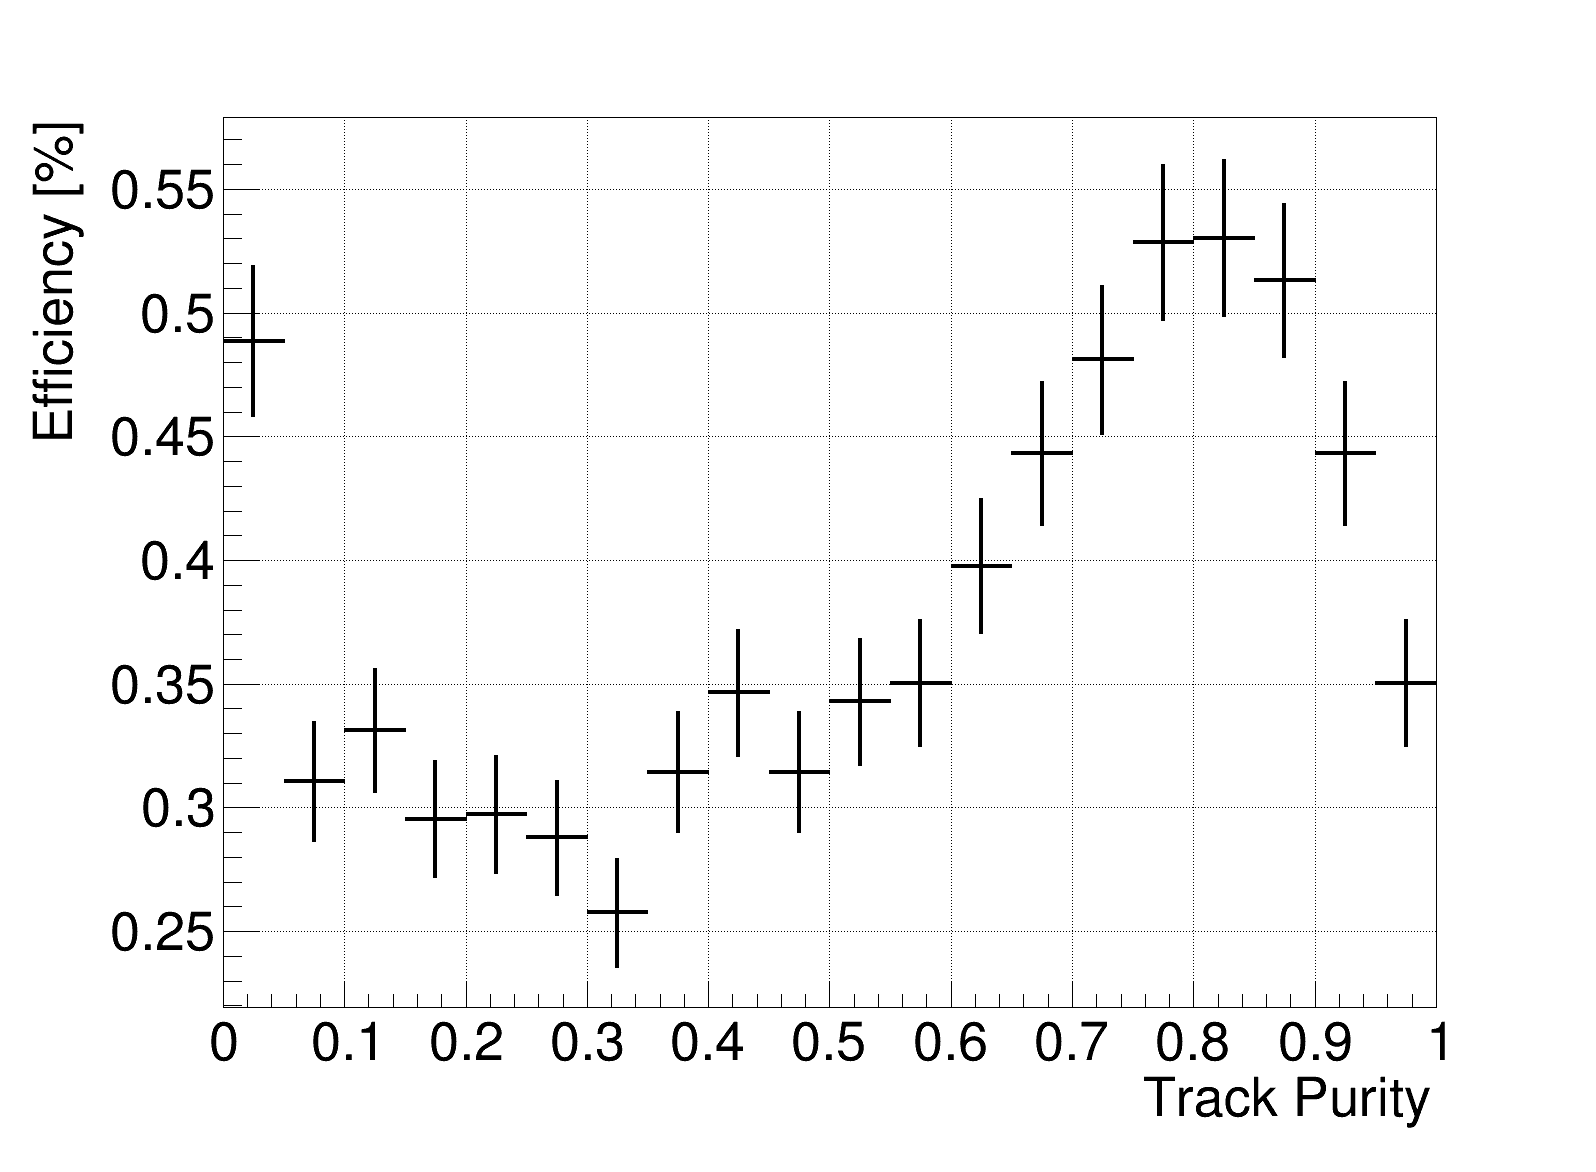

In [11]:
h_temp = ROOT.TH1F("h_temp",'h_temp',200,0,1)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',200,0,1)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',20,0,1)
cut = 'MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05'
overlay.Draw('MCTrackPurity'+'>>h_temp',cut,'')
overlay.Draw('MCTrackPurity'+'>>h_temp1',cut+' && MCTrackPDG==11 && '+matching,'')

h_temp.SetXTitle("Track Purity (all tracks in nu event)")
h_temp.SetYTitle("# events")
h_temp.GetYaxis().SetTitleSize(0.05)
h_temp.GetYaxis().SetTitleOffset(1.3)
h_temp.GetYaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleSize(0.05)
h_temp.GetXaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleOffset(1)
h_temp.SetLineColor(ROOT.kBlack)
h_temp.SetLineWidth(4)
h_temp1.SetLineColor(ROOT.kGreen)
h_temp1.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_temp.Draw('')
h_temp1.Draw('same')
prelim = draw_sim()
prelim.Draw()
legend = ROOT.TLegend(0.15,0.65,0.5,0.9)
legend.AddEntry(h_temp,'all nue',"lep");
legend.AddEntry(h_temp1,'matched nue',"lep");
legend.Draw()
print "Entries", h_temp.GetEntries()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h_purity_allTracks.root")
c1.SaveAs(outputdir_png + "h_purity_allTracks.png")
c1.SaveAs(outputdir_pdf + "h_purity_allTracks.pdf")

overlay.Draw('MCTrackPurity'+'>>h_temp2','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && '+matching,'')
nue_tot_rate = overlay_out.GetEntries('MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05')
h_temp2.Scale(100.0/nue_tot_rate)
h_temp2.SetXTitle("Track Purity")
h_temp2.SetYTitle("Efficiency [%]")
h_temp2.GetYaxis().SetTitleSize(0.05)
h_temp2.GetYaxis().SetTitleOffset(1.3)
h_temp2.GetYaxis().SetLabelSize(0.05)
h_temp2.GetXaxis().SetTitleSize(0.05)
h_temp2.GetXaxis().SetLabelSize(0.05)
h_temp2.GetXaxis().SetTitleOffset(1)
h_temp2.SetLineColor(ROOT.kBlack)
h_temp2.SetLineWidth(4)
t = ROOT.TLatex(0.1,4,'Matched electrons (>50%) from nue: \n {:04.1f} %'.format(h_temp2.Integral(10,20)));
t.SetTextFont(62);
t.SetTextSize(1/25.);

h_temp2.Draw()
t.Draw();
print h_temp2.Integral(0,20)
c1.Draw()
c1.SaveAs(outputdir_root + "h_purity.root")
c1.SaveAs(outputdir_png + "h_purity.png")
c1.SaveAs(outputdir_pdf + "h_purity.pdf")

MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05


7501

Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_Momentum.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_Momentum.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_Momentum.pdf has been created


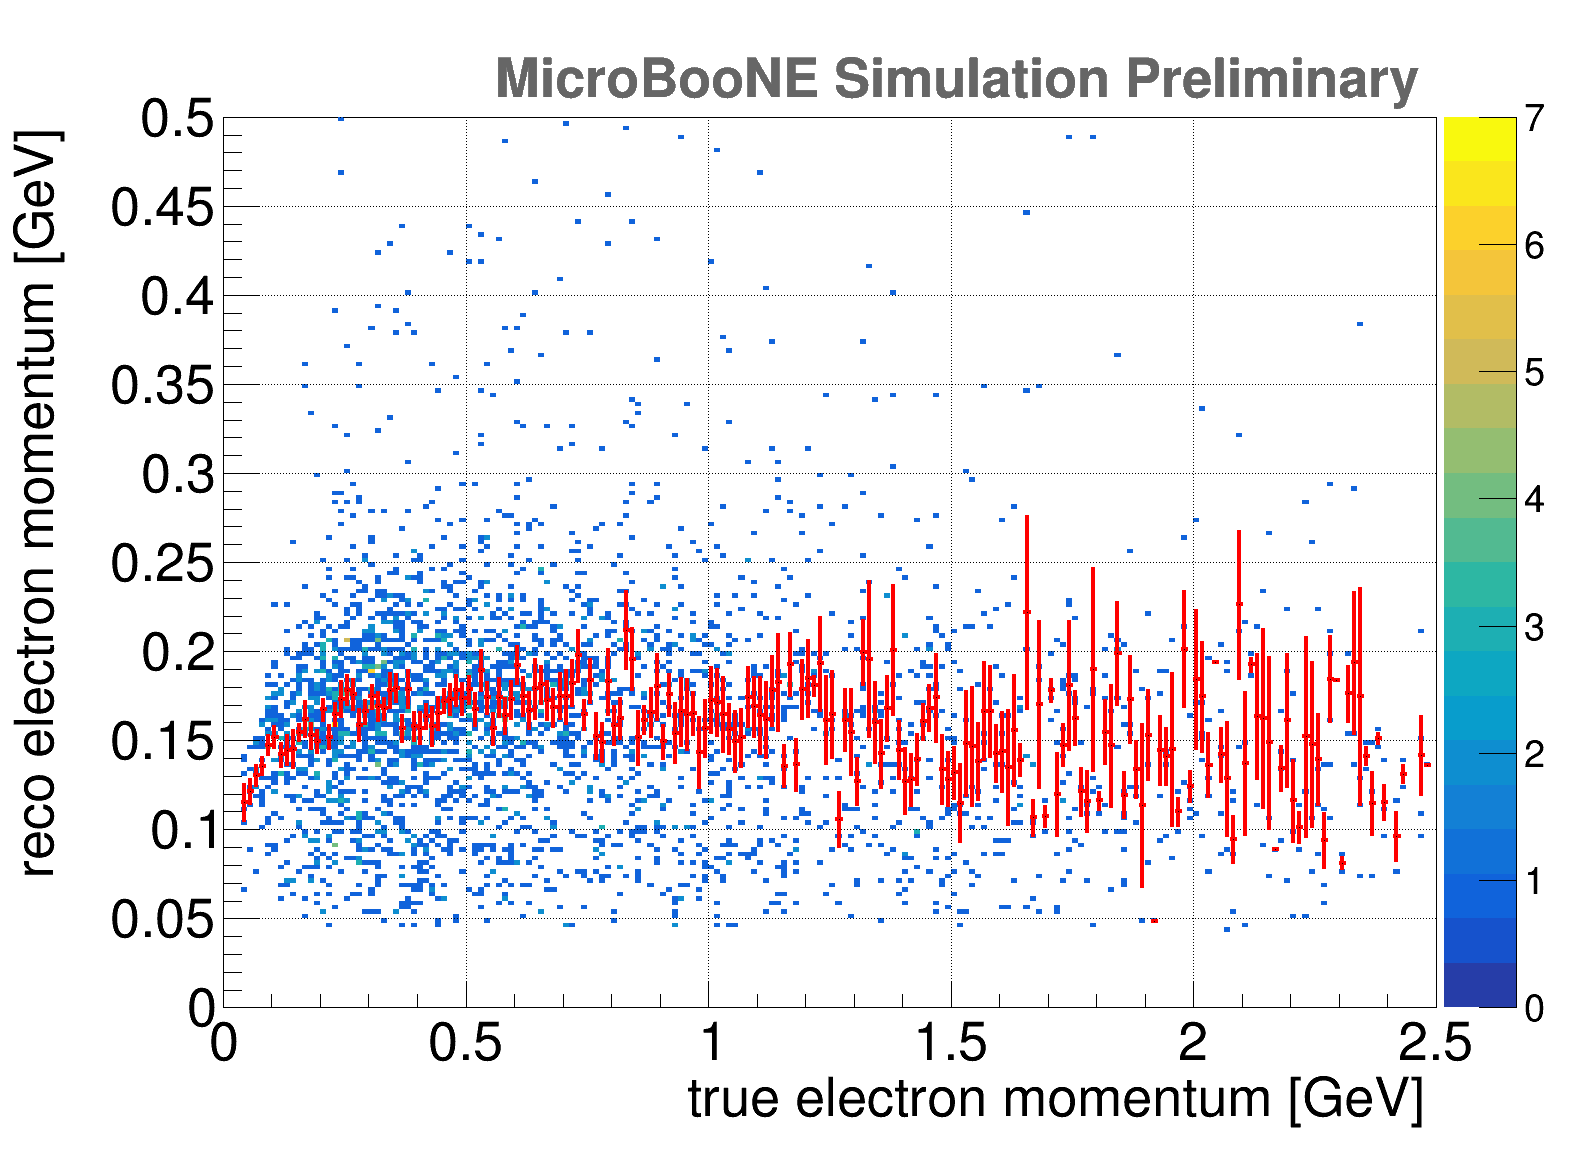

In [12]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,0.5)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomMCS_mom:MCle_Energy'+'>>h_migration',cut+' && track_end_uncontained','')
overlay.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
#h_prof2 = h_migration.ProfileY()
#h_prof2.SetLineWidth(4)
#h_prof2.SetLineColor(ROOT.kOrange)
#h_prof2.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_Momentum.root")
c1.SaveAs(outputdir_png + "h2_true_Momentum.png")
c1.SaveAs(outputdir_pdf + "h2_true_Momentum.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


6511

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_MCS.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_MCS.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_MCS.pdf has been created


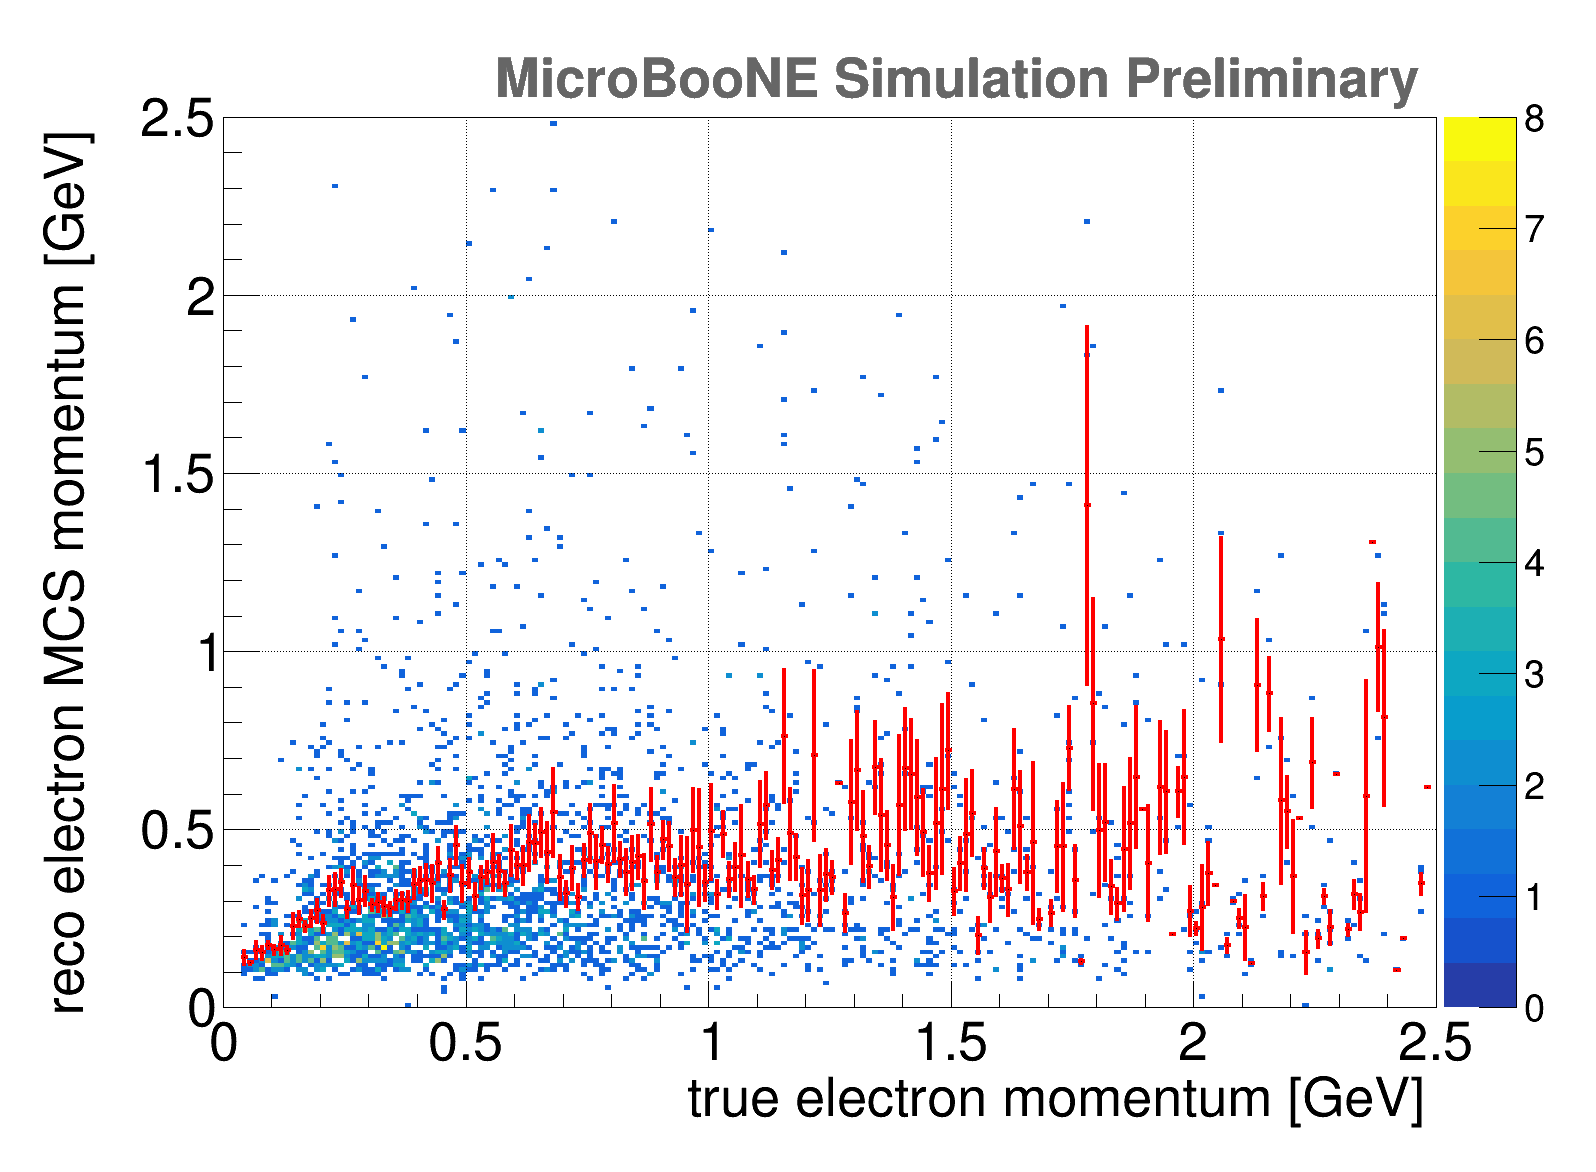

In [13]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomMCS_mom:MCTrackMomentum'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron MCS momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_MCS.root")
c1.SaveAs(outputdir_png + "h2_true_MCS.png")
c1.SaveAs(outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


6992

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_MCS.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_MCS.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_MCS.pdf has been created


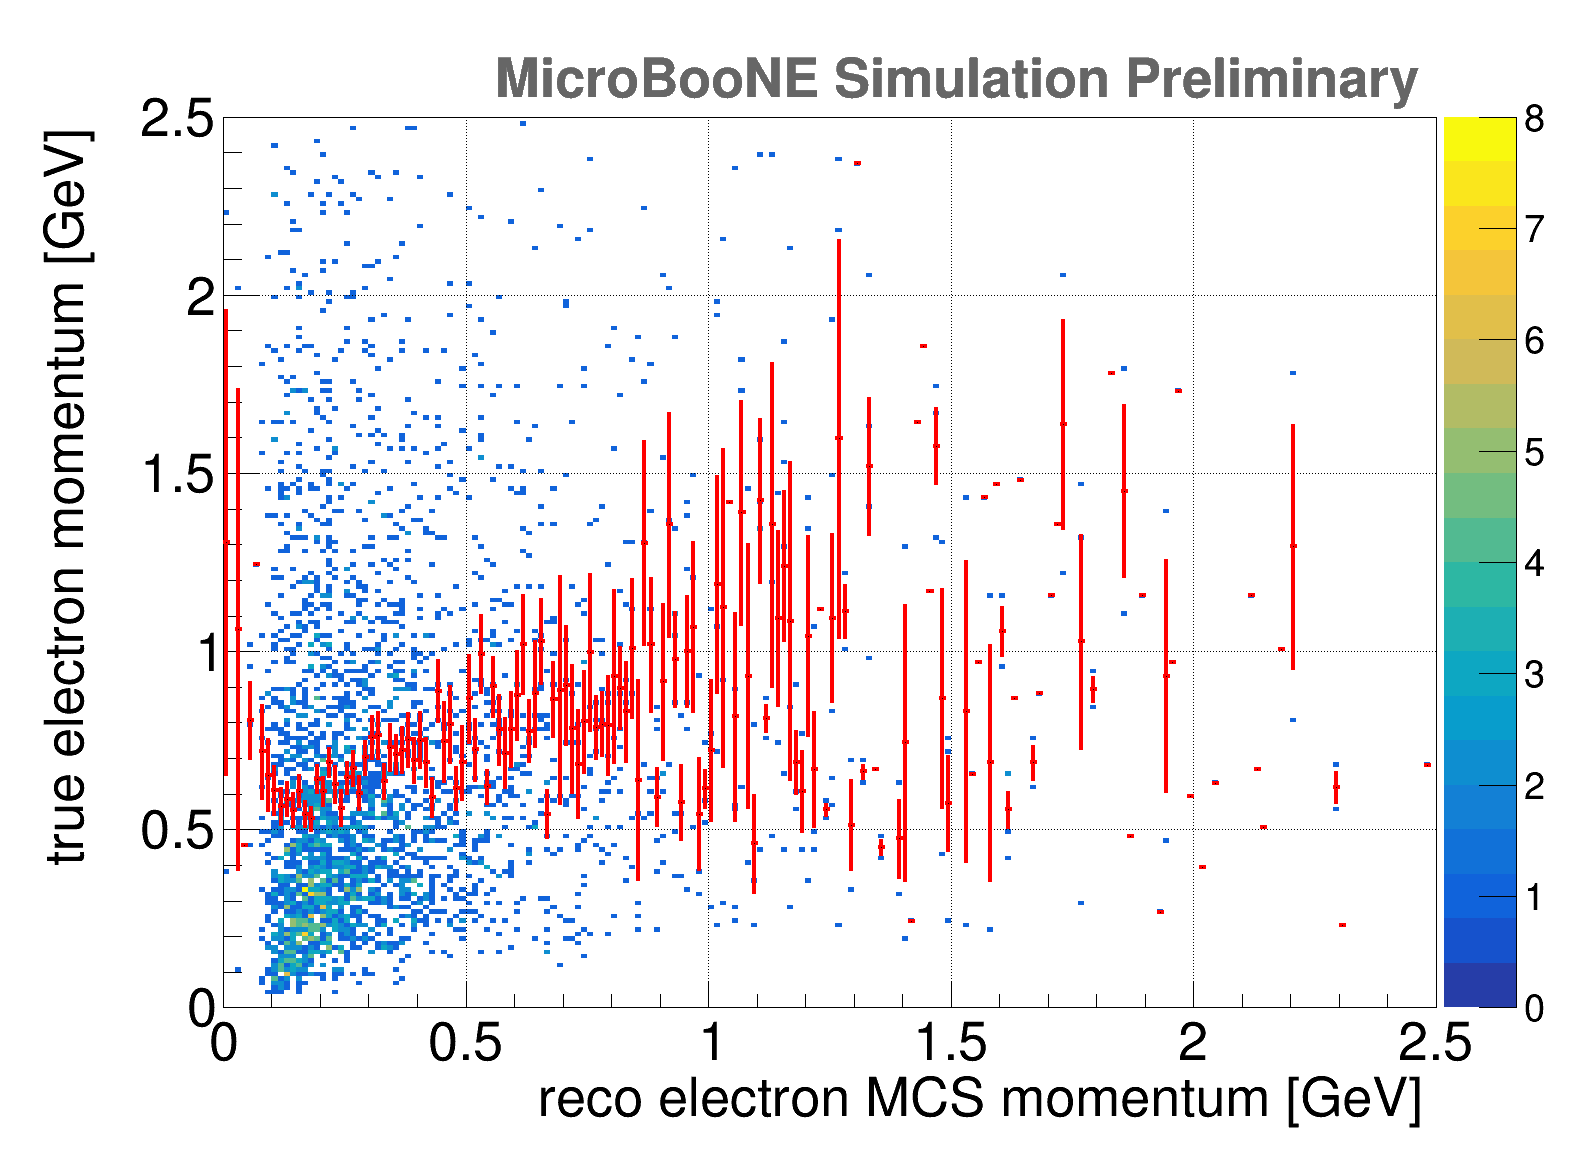

In [14]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('MCTrackMomentum:TrackMomMCS_mom'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetYTitle("true electron momentum [GeV]")
h_migration.SetXTitle("reco electron MCS momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_MCS.root")
c1.SaveAs(outputdir_png + "h2_true_MCS.png")
c1.SaveAs(outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


23131

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_MCS_zoom.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_MCS_zoom.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_MCS_zoom.pdf has been created


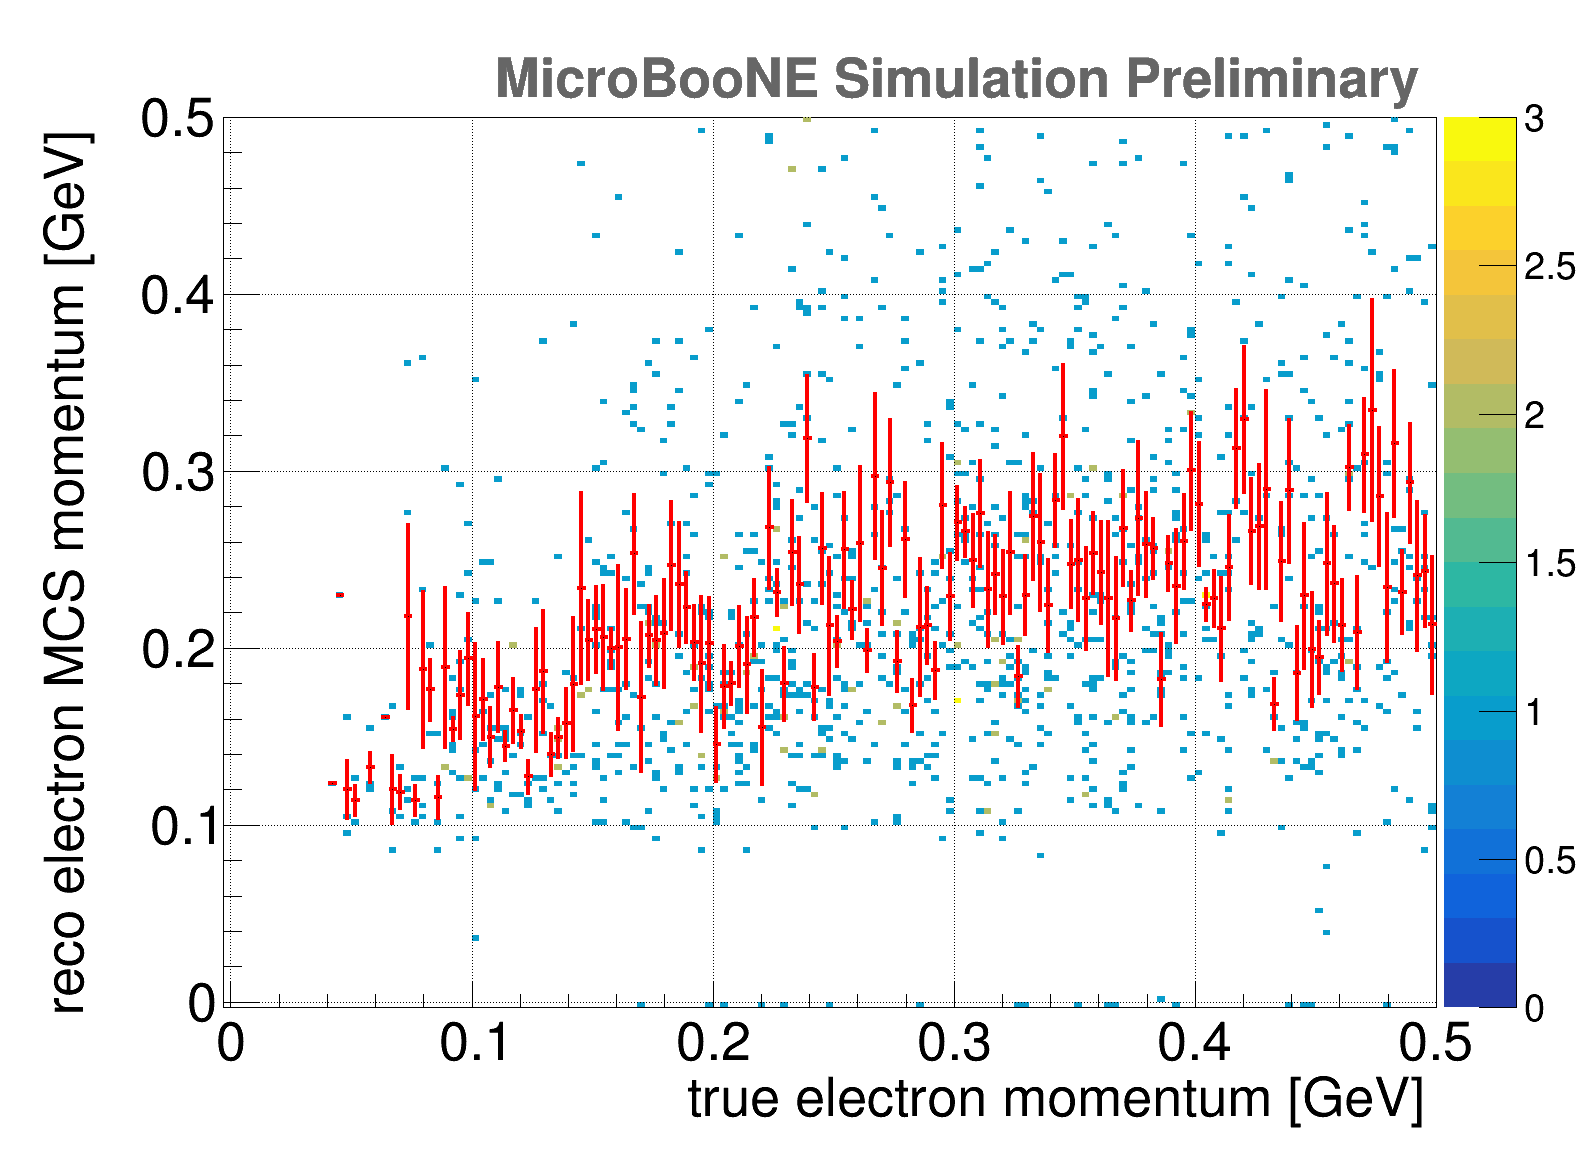

In [15]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',800,0,2.5,800,0,2.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomMCS_mom:MCTrackMomentum'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron MCS momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.GetYaxis().SetRange(0,160)
h_migration.GetXaxis().SetRange(0,160)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_MCS_zoom.root")
c1.SaveAs(outputdir_png + "h2_true_MCS_zoom.png")
c1.SaveAs(outputdir_pdf + "h2_true_MCS_zoom.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


7180

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_range.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_range.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_range.pdf has been created


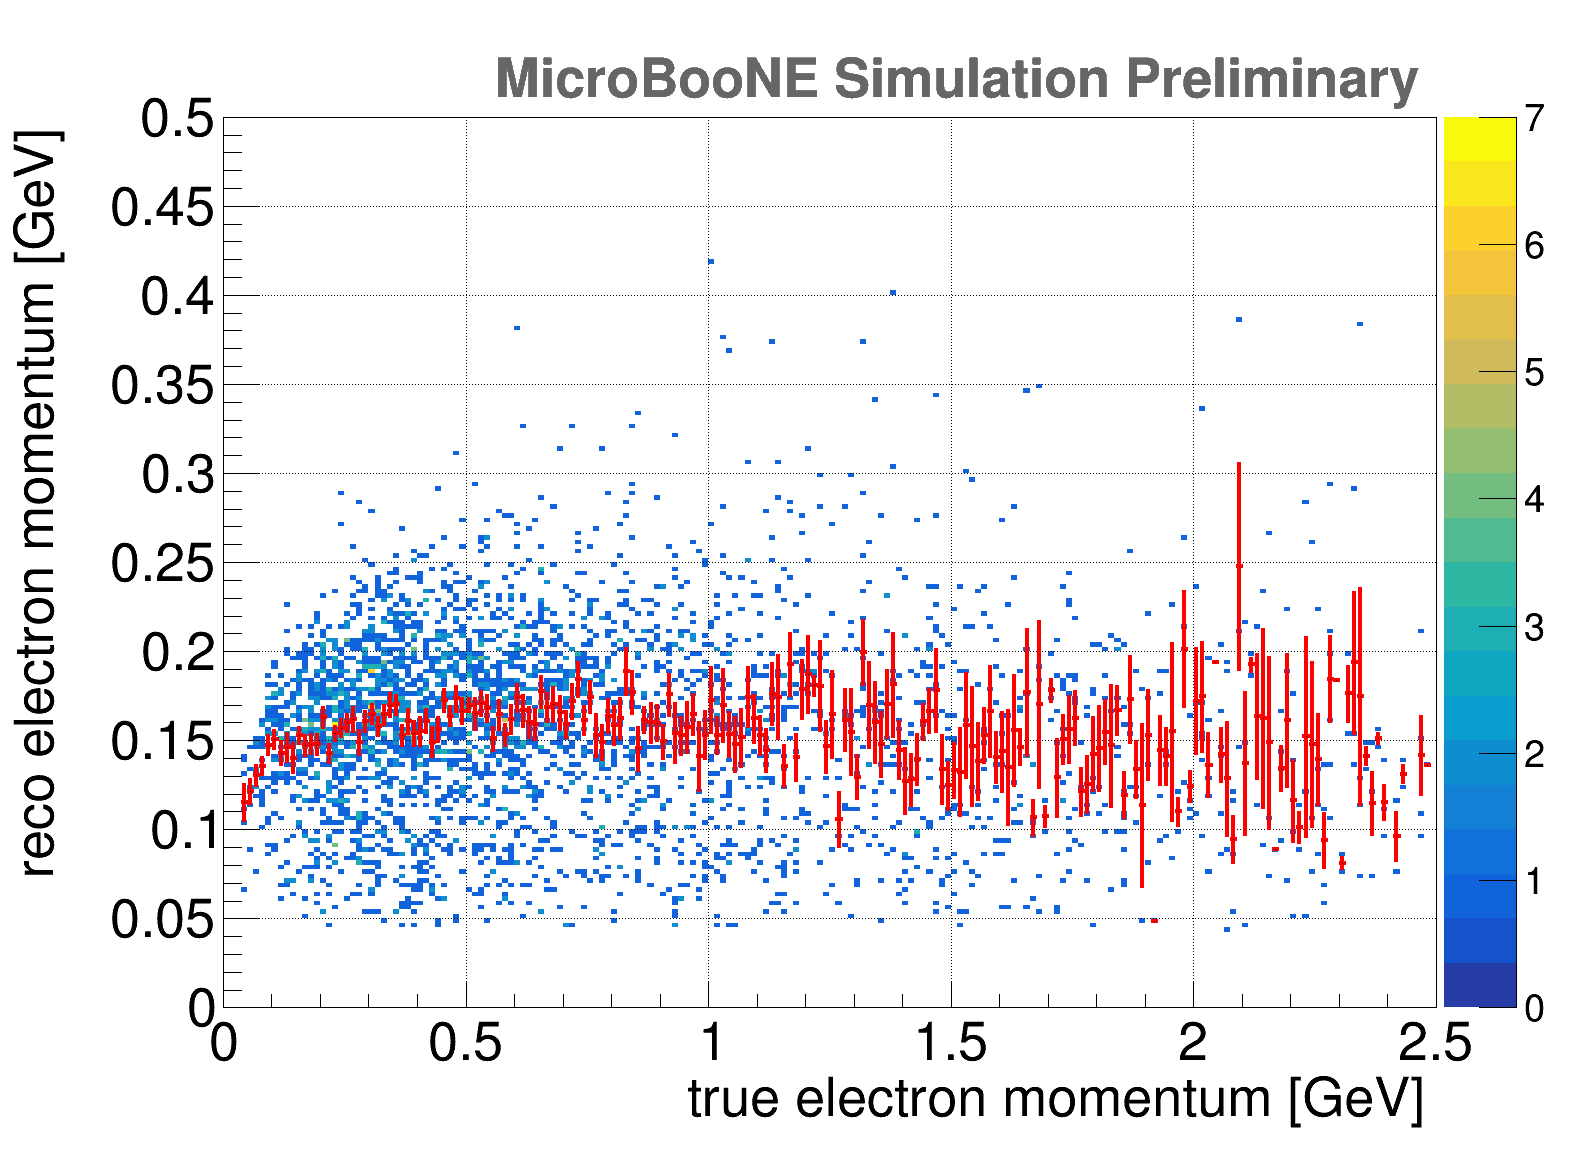

In [16]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,0.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomRange_mu:MCTrackMomentum'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_range.root")
c1.SaveAs(outputdir_png + "h2_true_range.png")
c1.SaveAs(outputdir_pdf + "h2_true_range.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


5543

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_range_zoom.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_range_zoom.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_range_zoom.pdf has been created


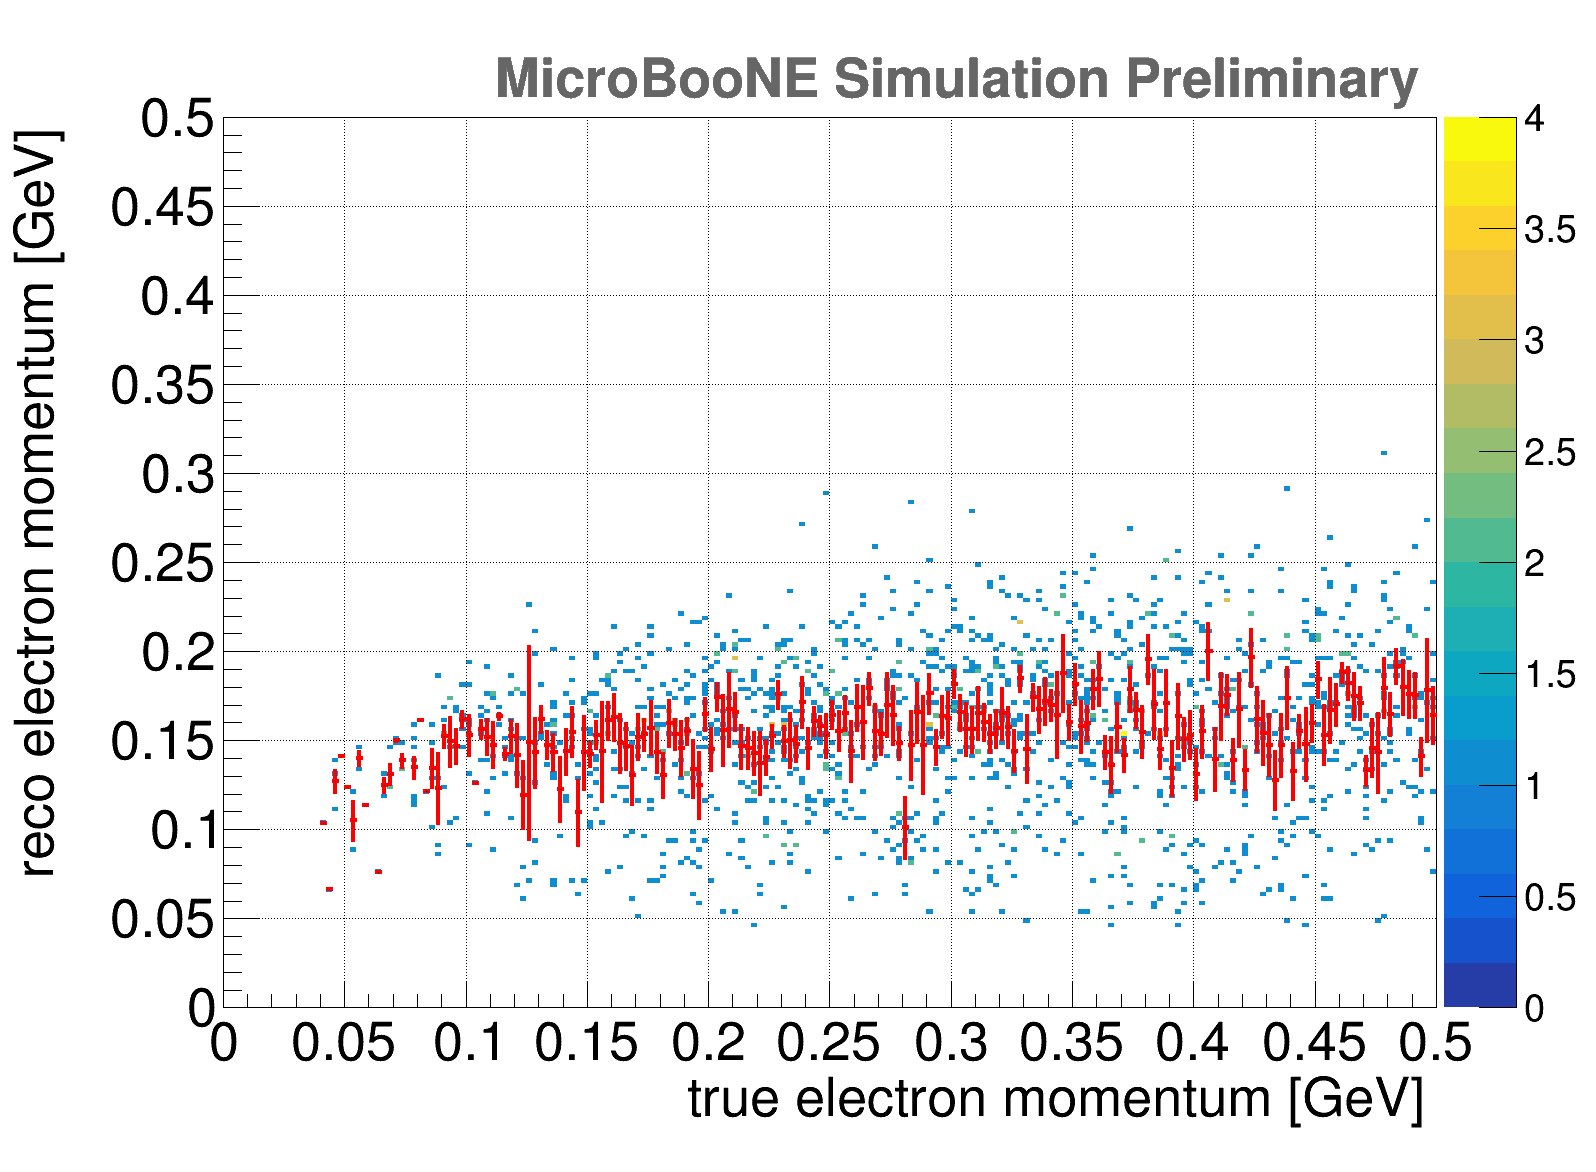

In [17]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,0.5,200,0,0.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomRange_mu:MCTrackMomentum'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_range_zoom.root")
c1.SaveAs(outputdir_png + "h2_true_range_zoom.png")
c1.SaveAs(outputdir_pdf + "h2_true_range_zoom.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


6466

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_r (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_theta.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_theta.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_theta.pdf has been created


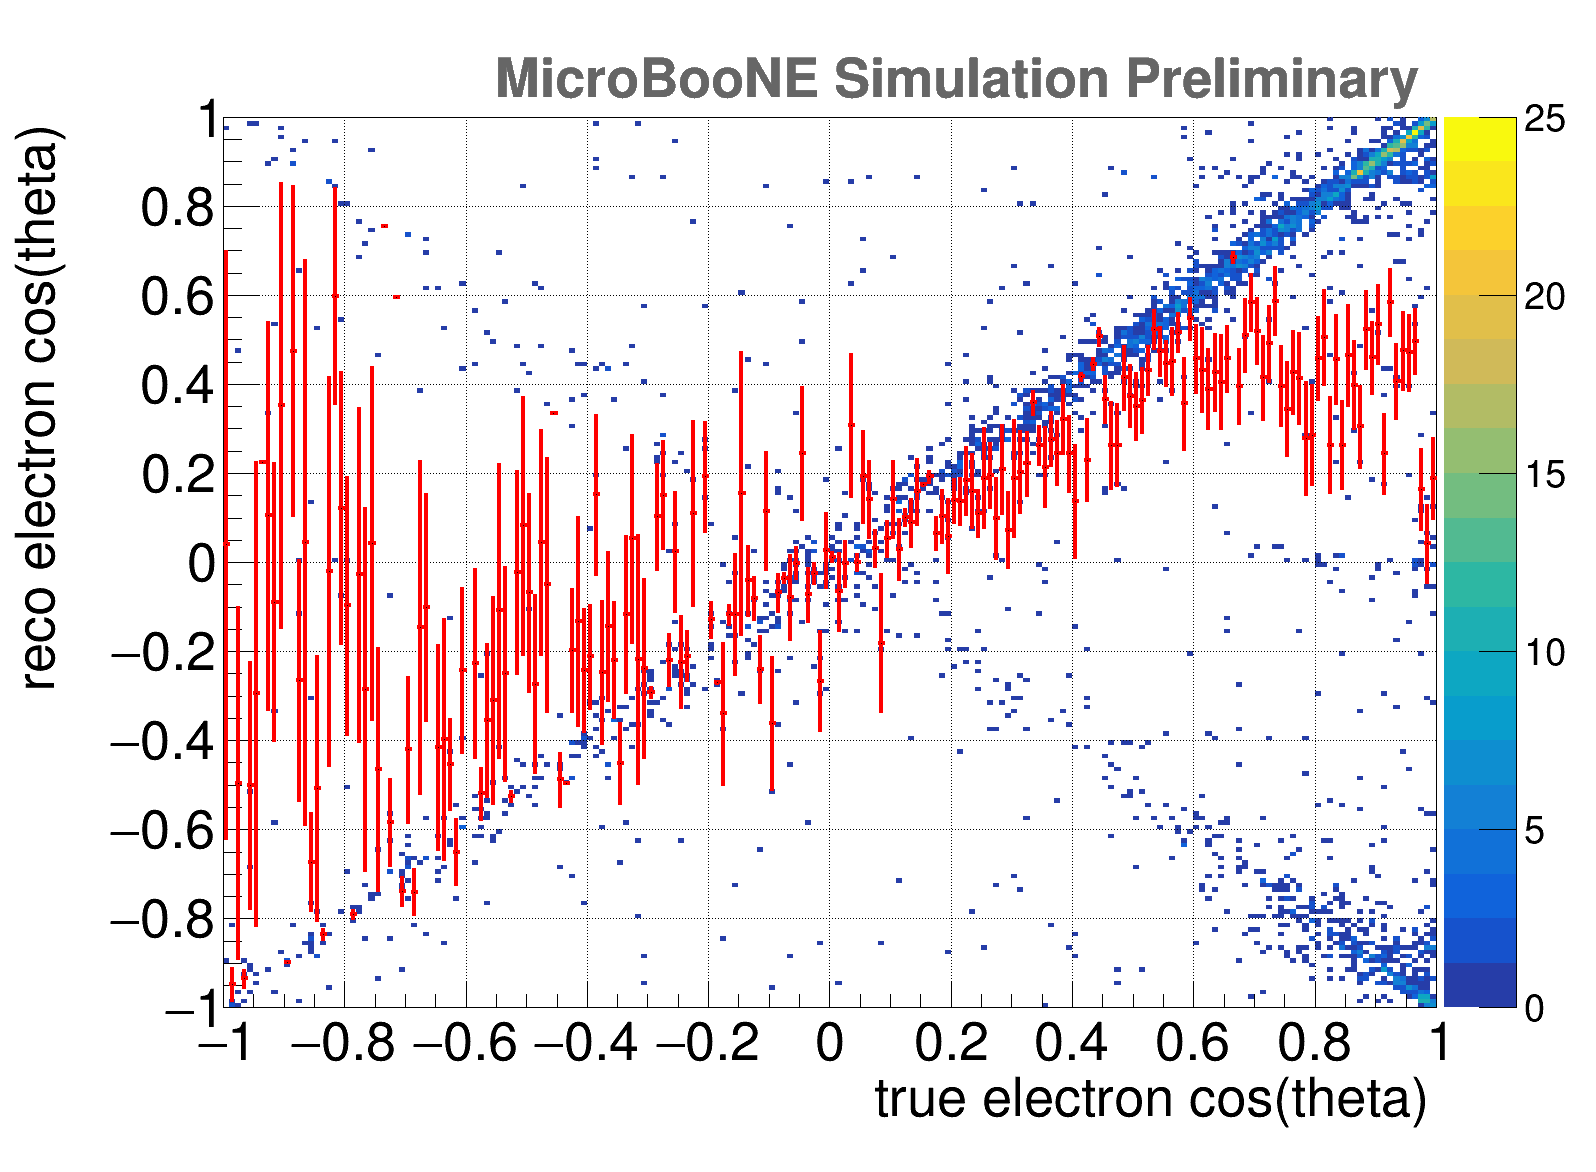

In [18]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,-1,1,200,-1,1)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('cos(TrackTheta):cos(MCTrackTheta)'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron cos(theta)")
h_migration.SetYTitle("reco electron cos(theta)")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_theta.root")
c1.SaveAs(outputdir_png + "h2_true_theta.png")
c1.SaveAs(outputdir_pdf + "h2_true_theta.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


7090

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_r (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_phi.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_phi.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_phi.pdf has been created


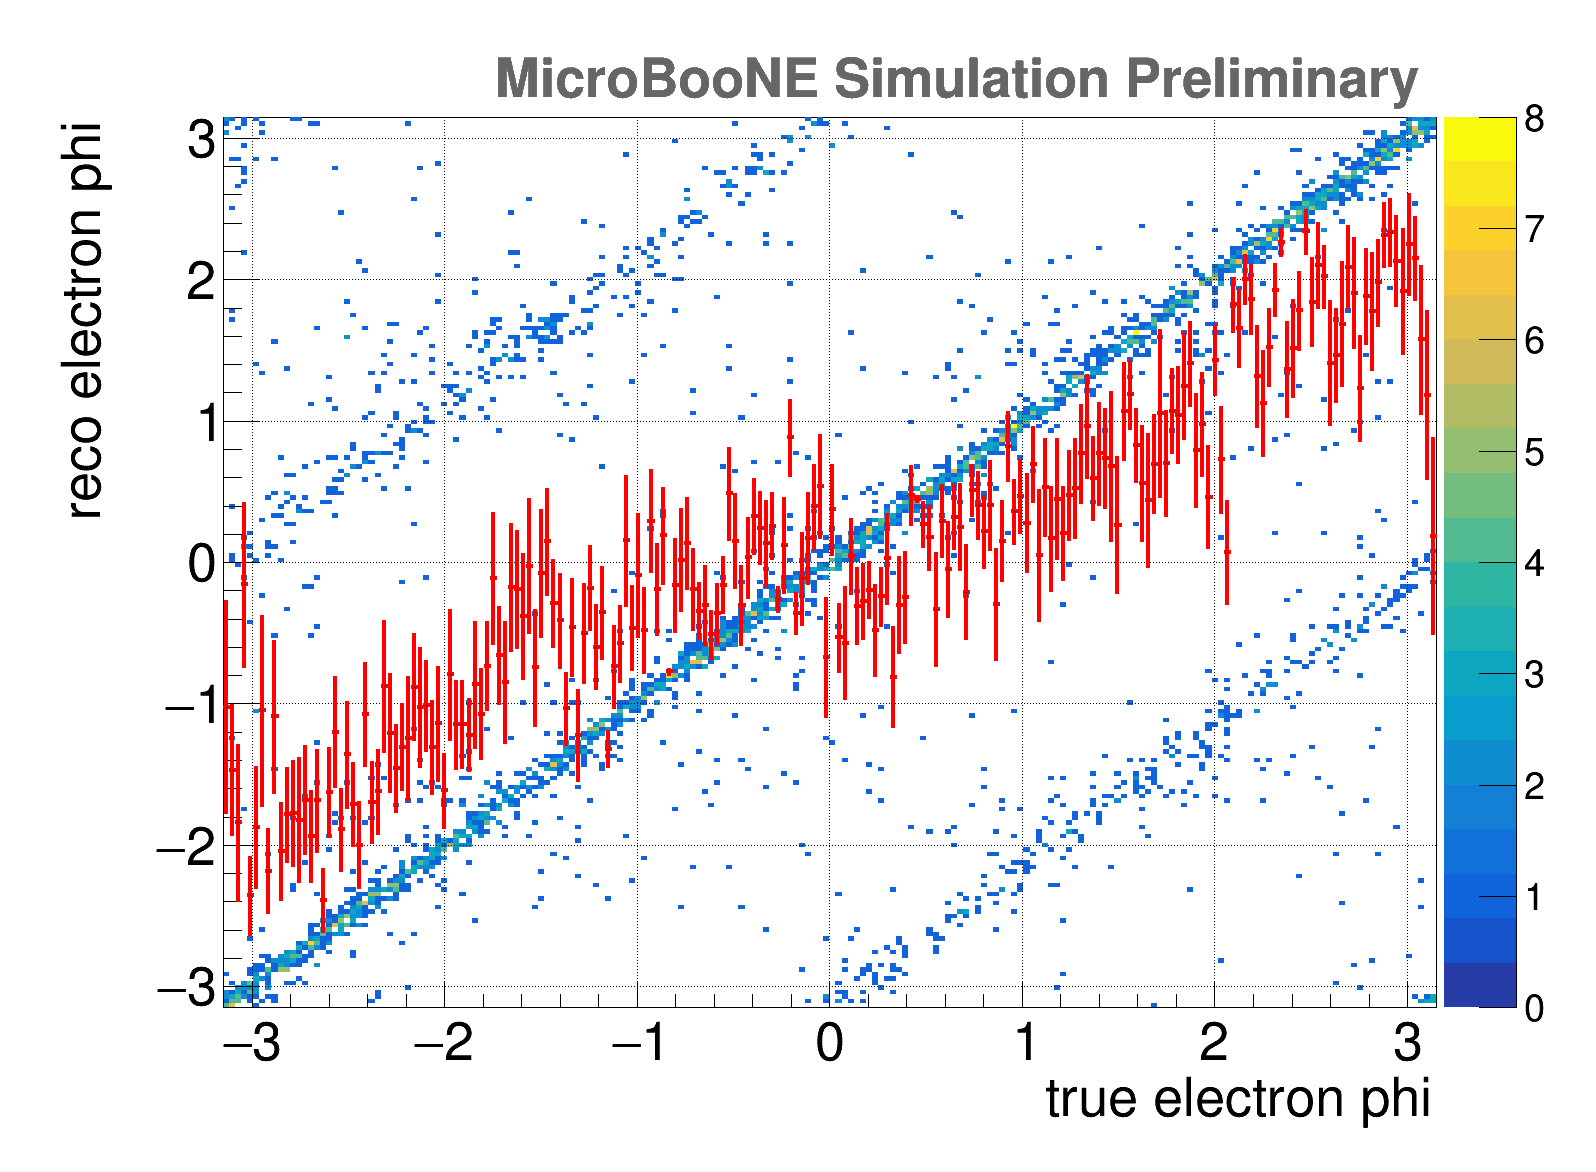

In [19]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,-3.15,3.15,200,-3.15,3.15)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackPhi:MCTrackPhi'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron phi")
h_migration.SetYTitle("reco electron phi")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_phi.root")
c1.SaveAs(outputdir_png + "h2_true_phi.png")
c1.SaveAs(outputdir_pdf + "h2_true_phi.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


7292

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_r (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_length.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_length.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_length.pdf has been created


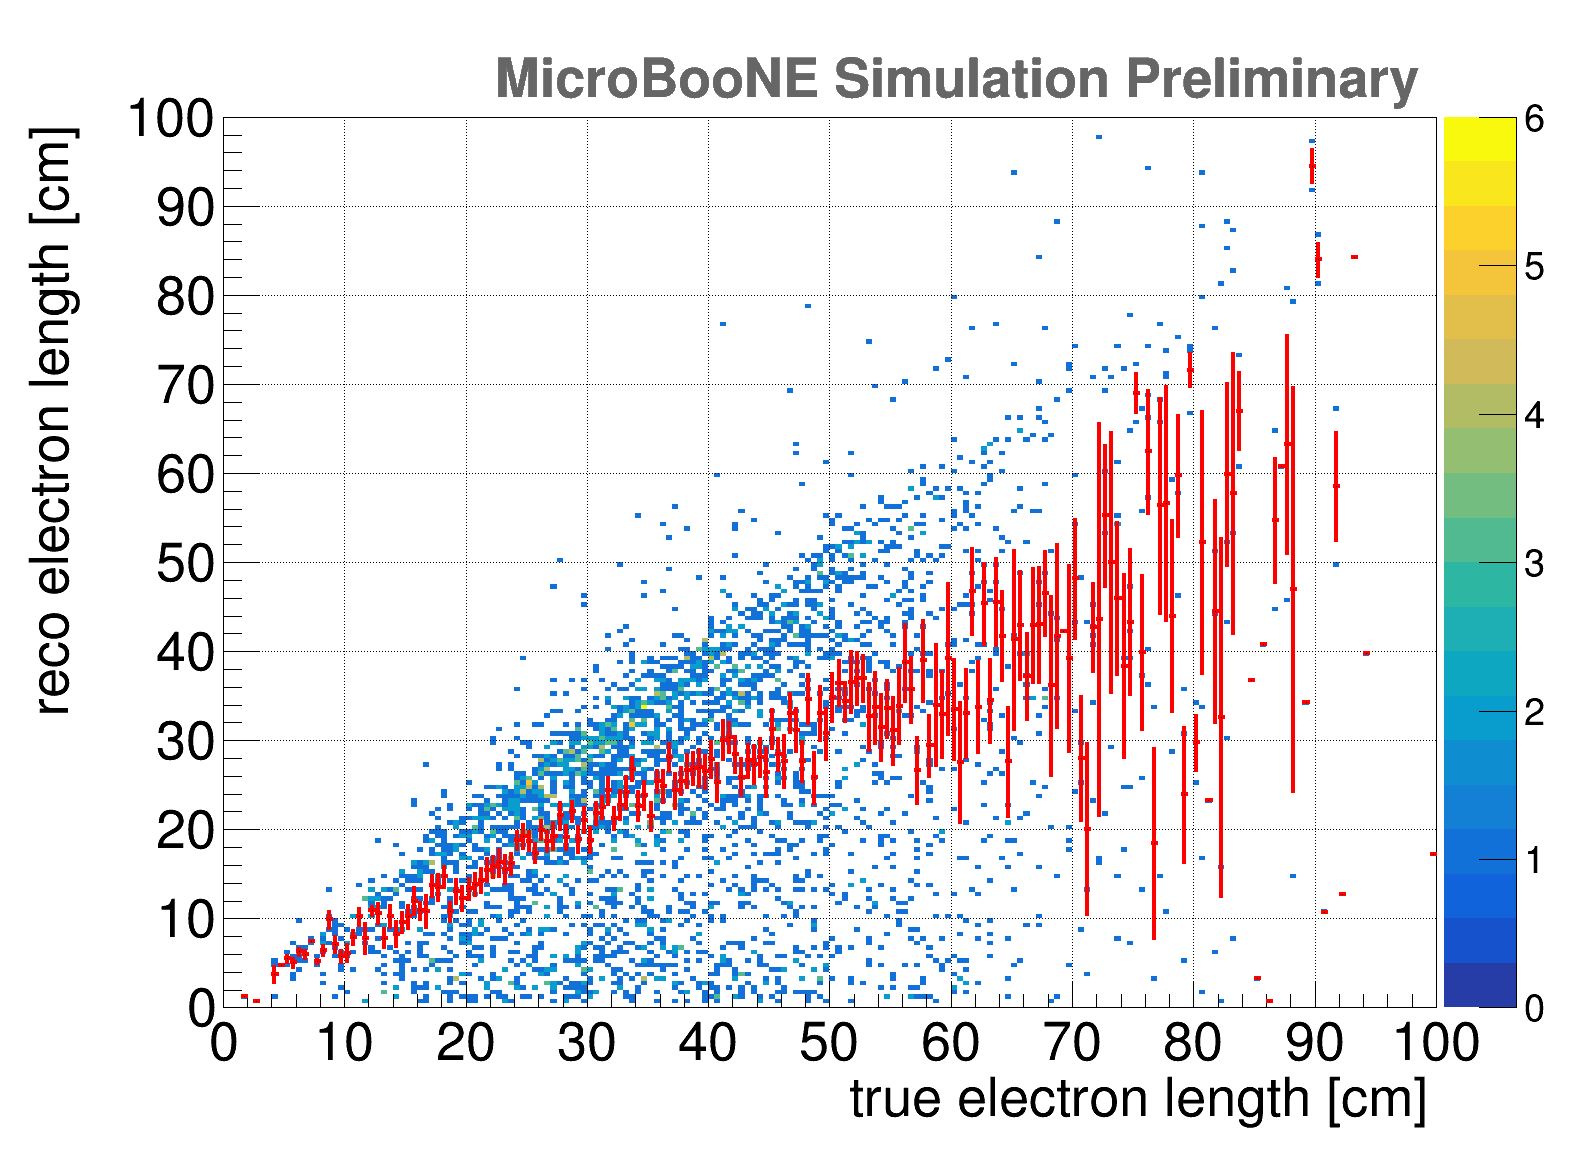

In [20]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,100,200,0,100)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackLength:MCTrackLength'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron length [cm]")
h_migration.SetYTitle("reco electron length [cm]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_length.root")
c1.SaveAs(outputdir_png + "h2_true_length.png")
c1.SaveAs(outputdir_pdf + "h2_true_length.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


598

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_length.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_length.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_length.pdf has been created


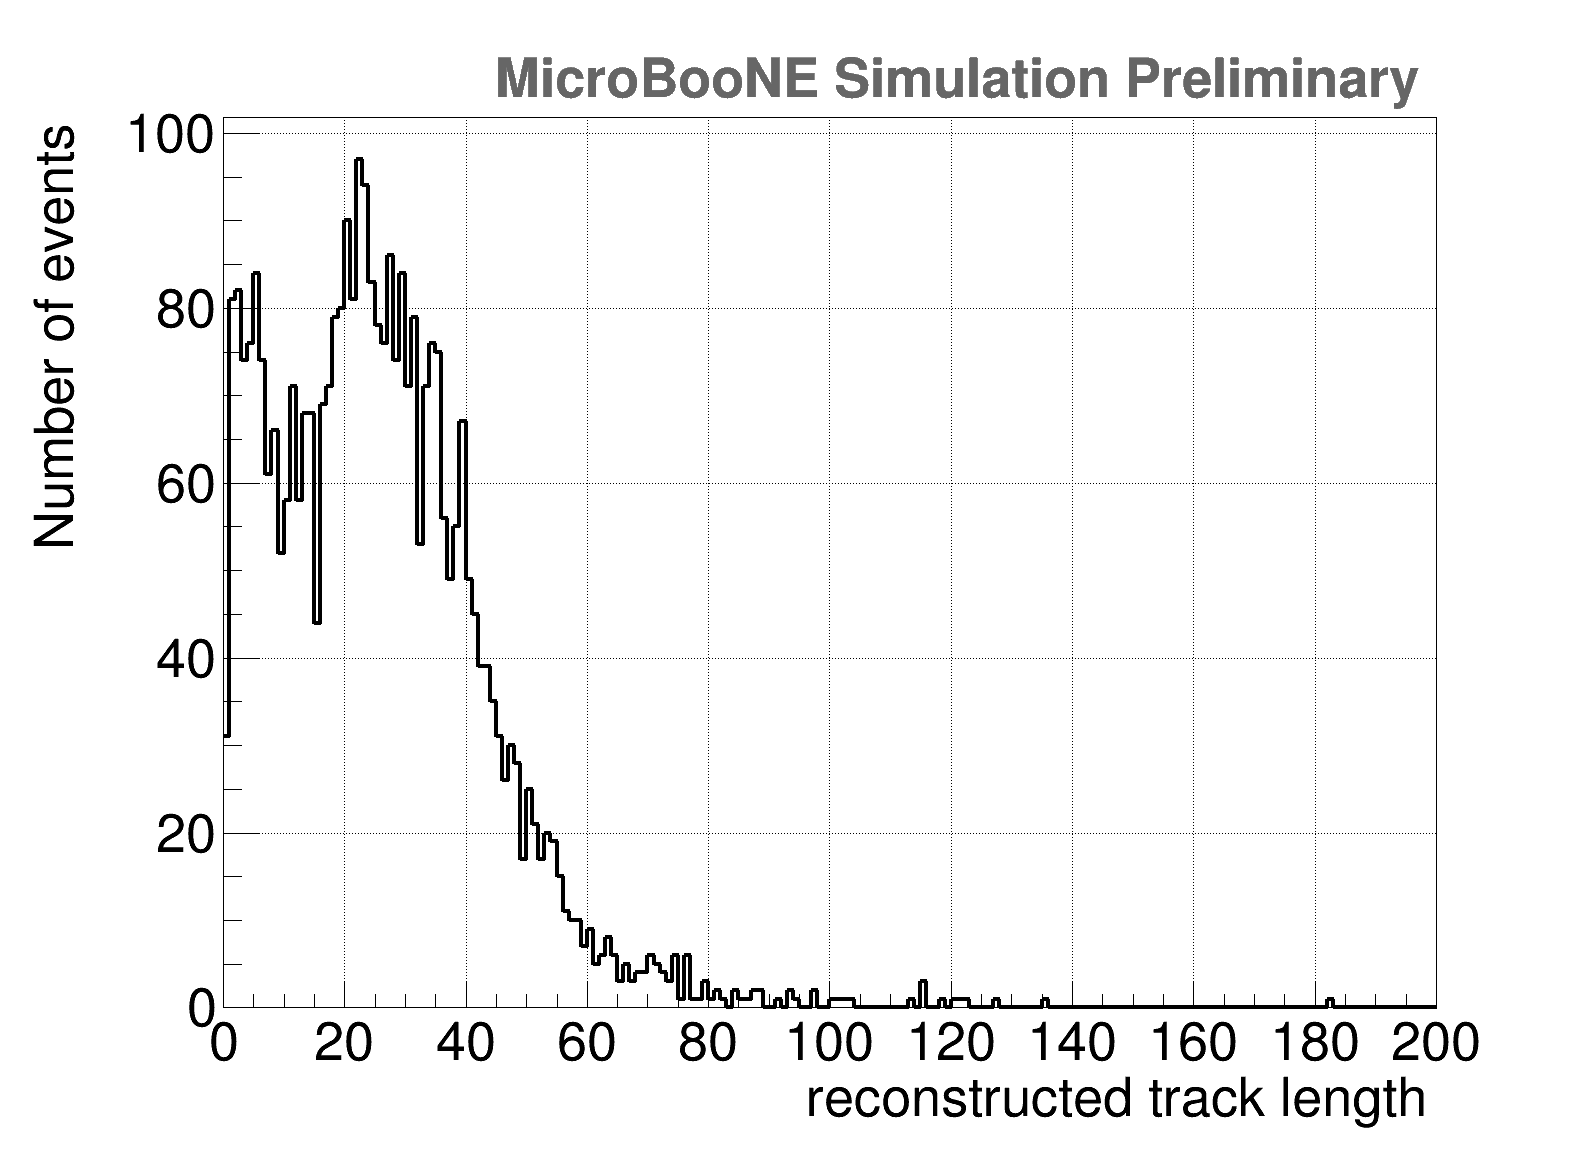

In [21]:
h_migration = ROOT.TH1F("h_migration",'Truth vs. Reco',200,0,200)
h_migration_all = ROOT.TH1F("h_migration_all",'Truth vs. Reco',200,0,200)
print cut
cut = 'MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
#overlay.Draw('TrackLength'+'>>h_migration_all','MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12','')
overlay.Draw('TrackLength'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("reconstructed track length")
h_migration.SetYTitle("Number of events")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
#h_migration.SetMaximum(h_migration_all.GetMaximum()*1.2)
h_migration.Draw("")
#h_migration_all.Draw('same')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_length.root")
c1.SaveAs(outputdir_png + "h2_true_length.png")
c1.SaveAs(outputdir_pdf + "h2_true_length.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


387

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_all (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/root/h2_true_length.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/png/h2_true_length.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check/pdf/h2_true_length.pdf has been created


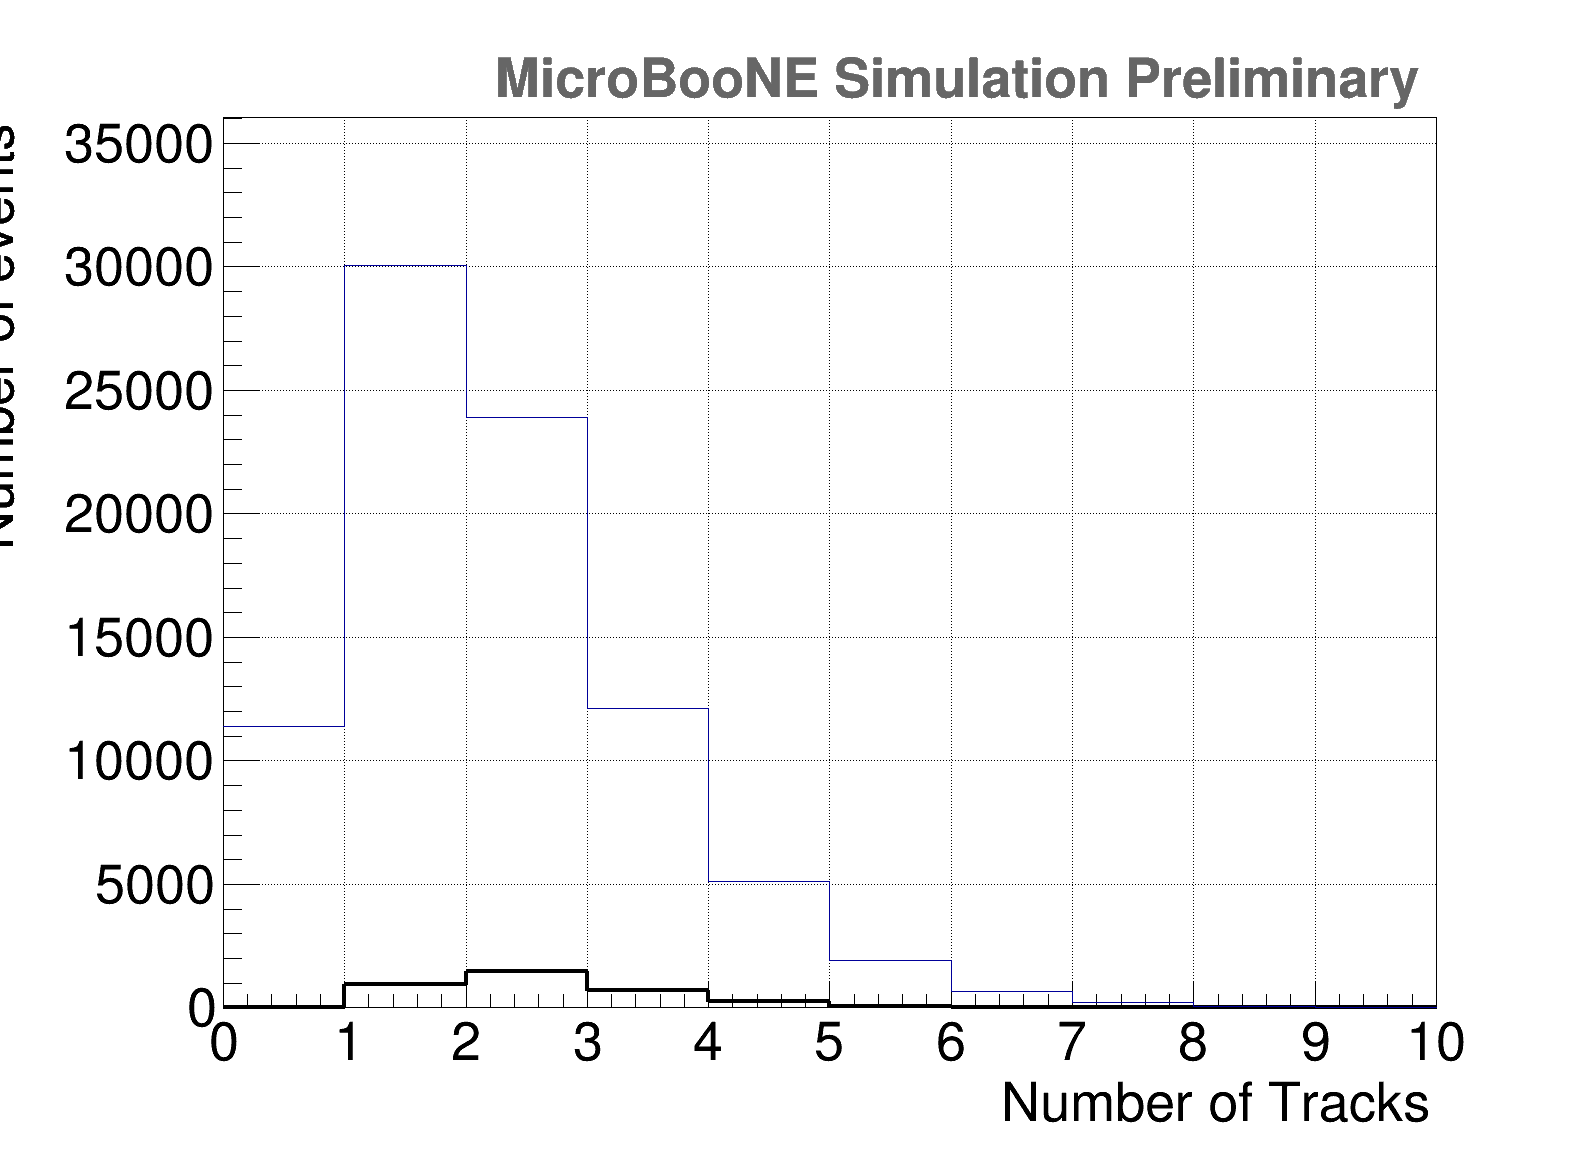

In [22]:
h_migration = ROOT.TH1F("h_migration",'Truth vs. Reco',10,0,10)
h_migration_all = ROOT.TH1F("h_migration_all",'Truth vs. Reco',10,0,10)
print cut
cut = 'MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('NuTracks'+'>>h_migration_all','MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12','')
overlay.Draw('NuTracks'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("Number of Tracks")
h_migration.SetYTitle("Number of events")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.SetMaximum(h_migration_all.GetMaximum()*1.2)
h_migration.Draw("")
h_migration_all.Draw('same')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_length.root")
c1.SaveAs(outputdir_png + "h2_true_length.png")
c1.SaveAs(outputdir_pdf + "h2_true_length.pdf")
h_migration.Write("h2_true_MCS_fine")

Entries 130979.0


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file h_temp.root has been created
Info in <TCanvas::Print>: png file h_temp.png has been created
Info in <TCanvas::Print>: pdf file h_temp.pdf has been created


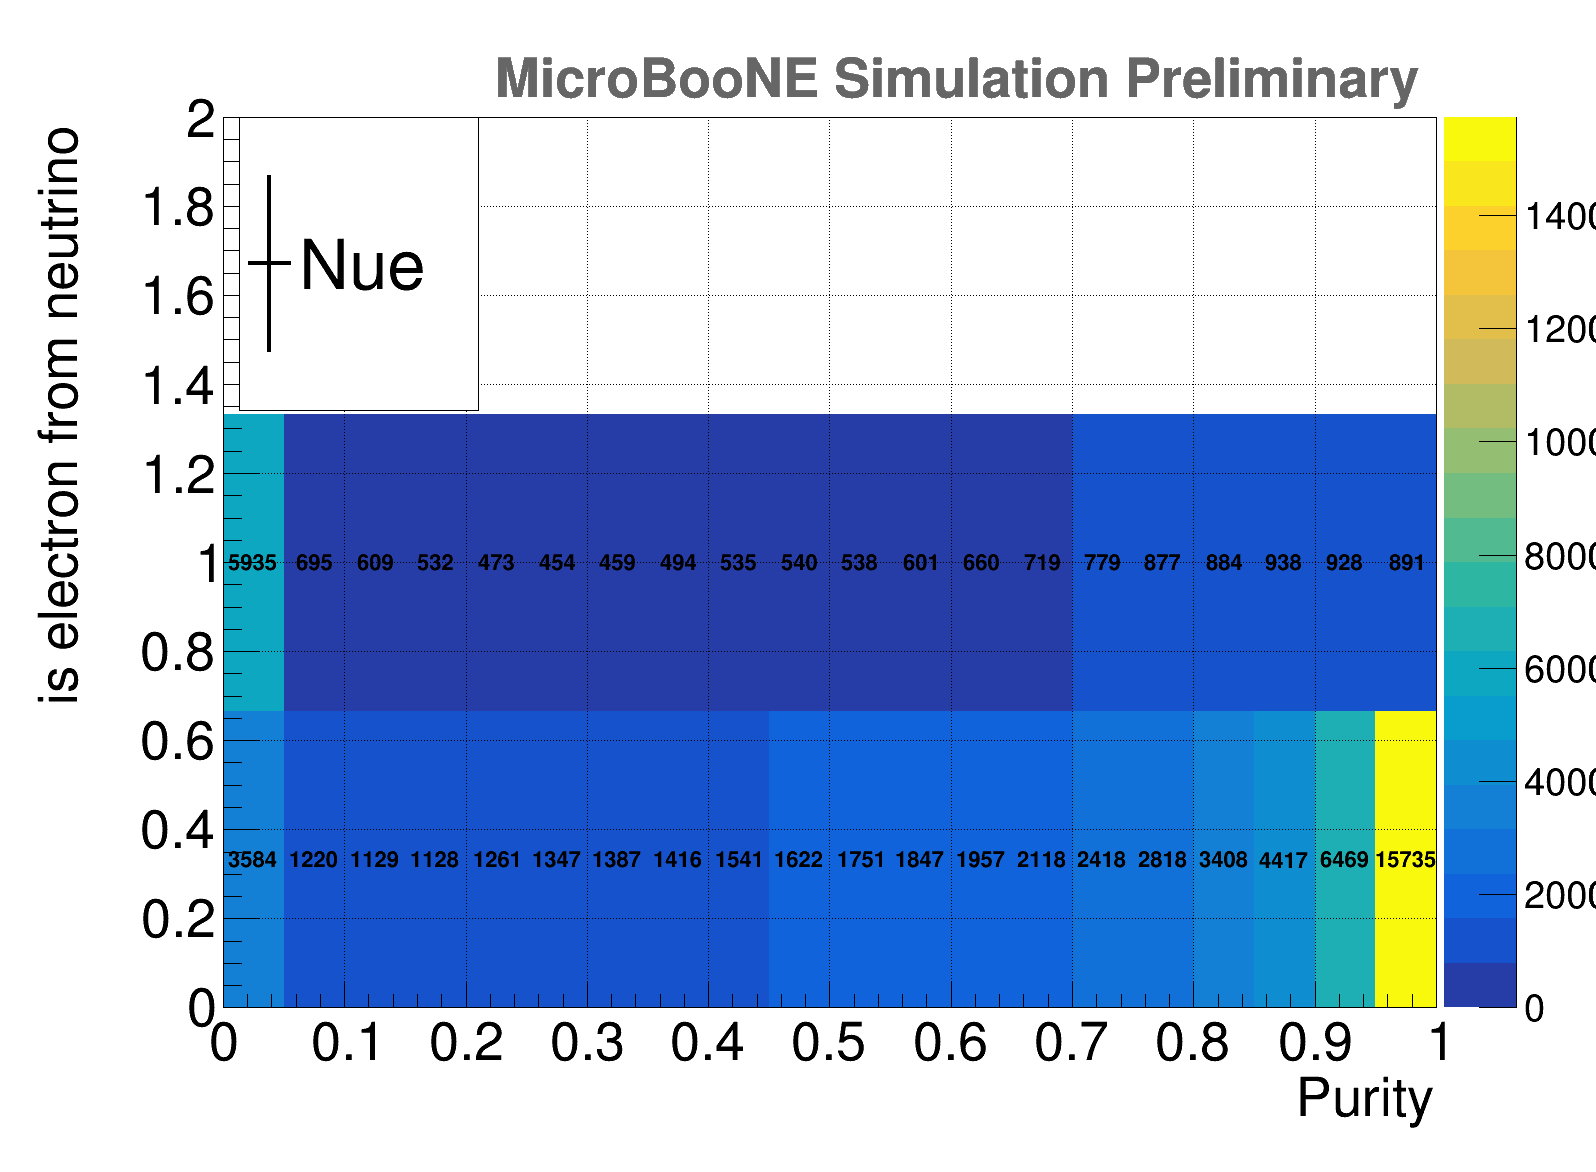

In [23]:
h_temp = ROOT.TH2F("h_temp",'h_temp',20,0,1,3,0,2)
overlay_out.Draw('(MCTrackPDG==11):MCTrackPurity'+'>>h_temp','','')
h_temp.SetXTitle("Purity")
h_temp.SetYTitle("is electron from neutrino")
h_temp.GetYaxis().SetTitleSize(0.05)
h_temp.GetYaxis().SetTitleOffset(1.3)
h_temp.GetYaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleSize(0.05)
h_temp.GetXaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleOffset(1)
h_temp.SetLineColor(ROOT.kBlack)
h_temp.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_temp.Draw('colz text')
prelim = draw_sim()
prelim.Draw()
legend = ROOT.TLegend(0.15,0.65,0.3,0.9)
legend.AddEntry(h_temp,'Nue',"lep");
legend.Draw()
print "Entries", h_temp.GetEntries()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h_temp.root")
c1.SaveAs(globale.outputdir_png + "h_temp.png")
c1.SaveAs(globale.outputdir_pdf + "h_temp.pdf")

MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


5934

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_r (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file h2_true_MCS.root has been created
Info in <TCanvas::Print>: png file h2_true_MCS.png has been created
Info in <TCanvas::Print>: pdf file h2_true_MCS.pdf has been created


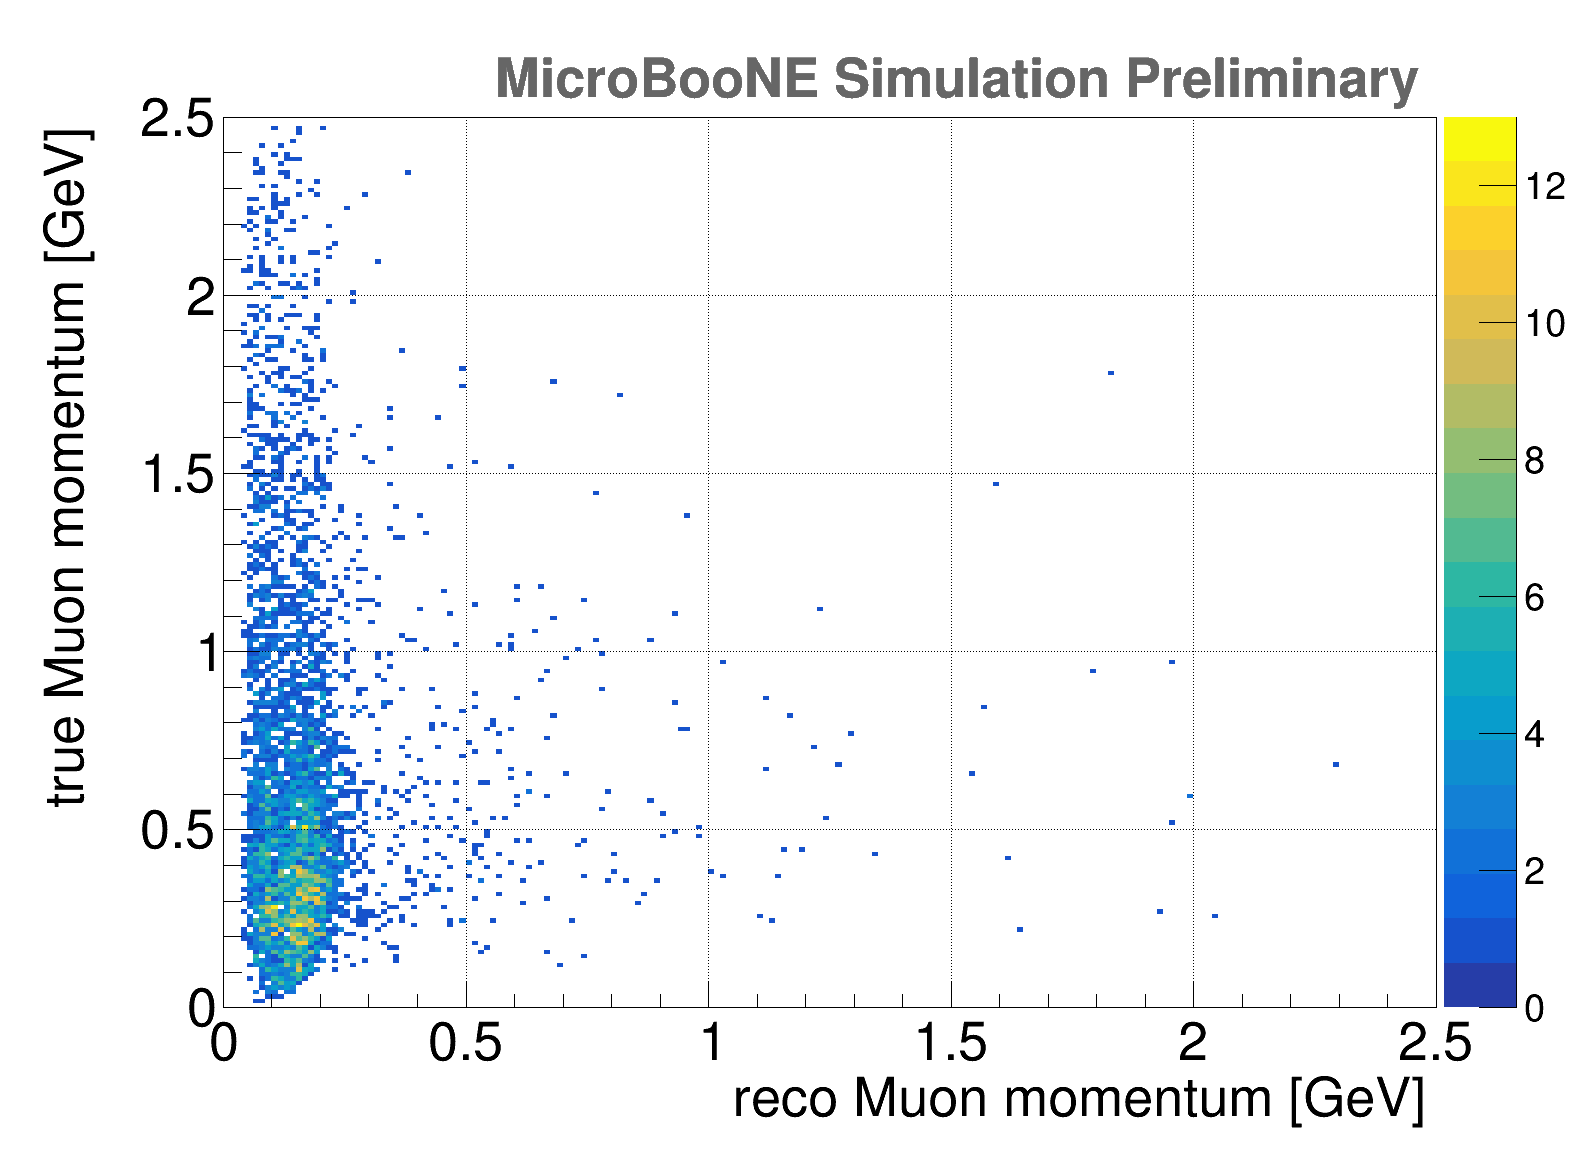

In [24]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,2.5)
print cut
overlay_out.Draw('MCle_Energy:TrackMomMCS_mom'+'>>h_migration',cut+' && track_end_uncontained','')
overlay_out.Draw('MCle_Energy:TrackMomRange_mu'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
h_migration.Add(h_migration_r)
h_migration.SetXTitle("reco Muon momentum [GeV]")
h_migration.SetYTitle("true Muon momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_MCS.root")
c1.SaveAs(globale.outputdir_png + "h2_true_MCS.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


5934

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_r (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file h2_true_MCS.root has been created
Info in <TCanvas::Print>: png file h2_true_MCS.png has been created
Info in <TCanvas::Print>: pdf file h2_true_MCS.pdf has been created


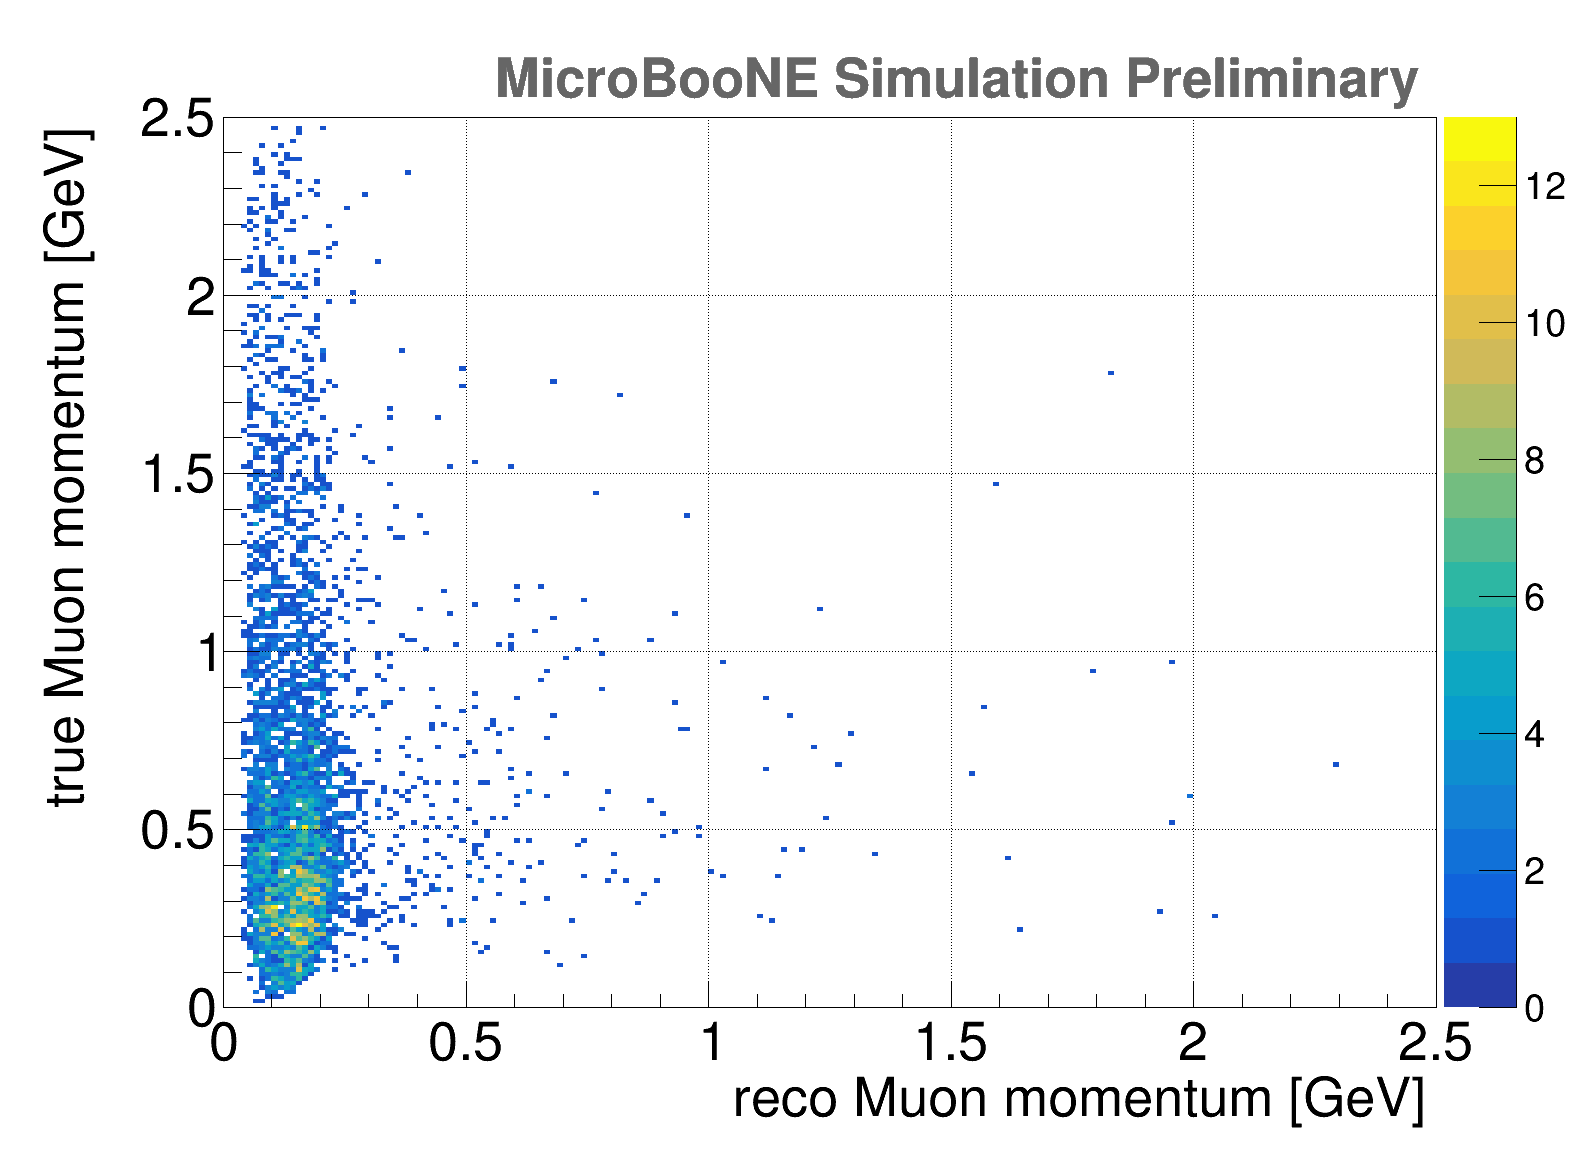

In [25]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,2.5)
print cut
overlay_out.Draw('MCle_Energy:TrackMomMCS_mom'+'>>h_migration',cut+' && track_end_uncontained','')
overlay_out.Draw('MCle_Energy:TrackMomRange_mu'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
h_migration.Add(h_migration_r)
h_migration.SetXTitle("reco Muon momentum [GeV]")
h_migration.SetYTitle("true Muon momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_MCS.root")
c1.SaveAs(globale.outputdir_png + "h2_true_MCS.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")